In [1]:
# 주요 라이브러리 버전 확인

import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [2]:
# 시계열 데이터 준비

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


# 삼성전자

In [3]:
#삼성전자의 종가만 가져옴
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time') # 결측치 보간. 보간기준 time
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

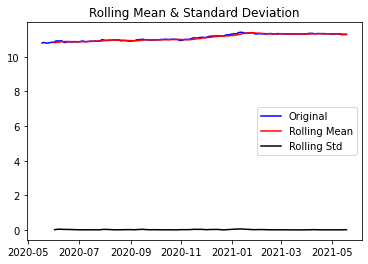

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


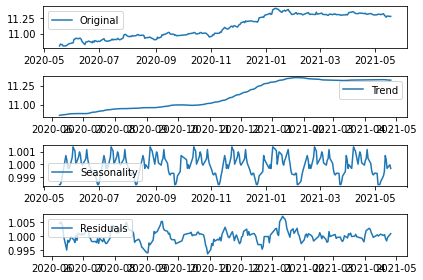

In [8]:
#시계열 안정성 분석

# 정성적 그래프 분석
 #이동평균을 이용한 구간 시각화
 # 좀더 뚜렷한 경향성을 확인 할 수 있다.

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
# 시계열의 안정성을 테스트 하는 방법

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# residuals 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


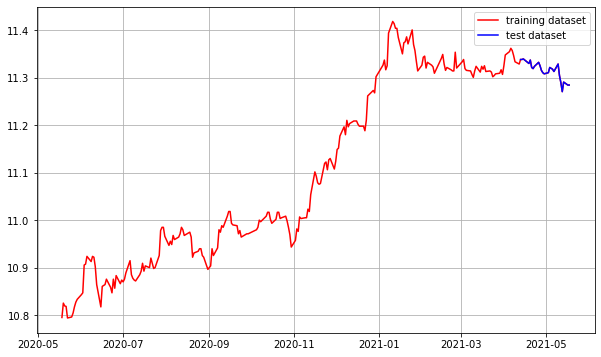

In [10]:
# 학습, 테스트 데이터 셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

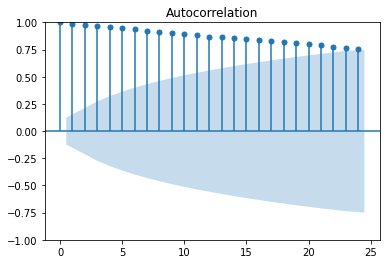

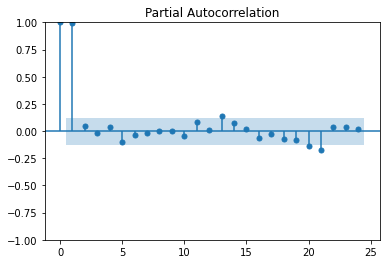

In [11]:
# 적정 ARIMA 모수 찾기
# ARIMA의 모수 3가지
# p : 자귀회귀 모형(AR)의 시차
# d : 차분 누적 횟수
# q : 이동평균 모형(MA)의 시차
# 일반적으로 q와 p는 p+q <2 , p*q= 0 인 값을 사용, 
# p*q = 0 은 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기때문
# international airline passengers 시계열 예시
# statsmodels에서 제공하는 ACF와 PACF 사용

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# PACF를 를 보았을때 p는 1일때 매우 적합
# p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.
# PACF가 0이라는 의미는 현재 데이터와 p시점 떨어진 이전의 데이터는 상관도가 0,
# 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

# ACF는 점차적으로 감소하고 있음
# q에 대하서는 적합한 값이 없어 보임
# MA 를 고려할 필요가 없다면 q=0으로 둘 수 있음, 하지만 q를 바꿔가면서 확인해보는 것도 좋음


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


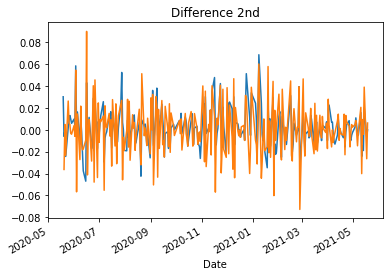

In [12]:
# 차분 안정성 구하기 (d)
# d를 구하기 위한 방법
# d차 차분을 구해보고 이때 시계열이 안정된 상태인지 확인

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 1차분 p-value = 2.2*e^(-28) 매우 안정, 1차분 이나 0차분 사용

In [15]:
# 모델 훈련과 테스트

#모델 훈련
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 0)) # 모수는 이전 그래프를 참고 #(p,d, q) = (2,0,0)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 583.409
Date:                Tue, 20 Sep 2022   AIC                          -1158.817
Time:                        07:46:43   BIC                          -1145.153
Sample:                             0   HQIC                         -1153.302
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.132     83.895      0.000      10.831      11.349
ar.L1          1.0296      0.061     16.764      0.000       0.909       1.150
ar.L2         -0.0350      0.062     -0.562      0.5

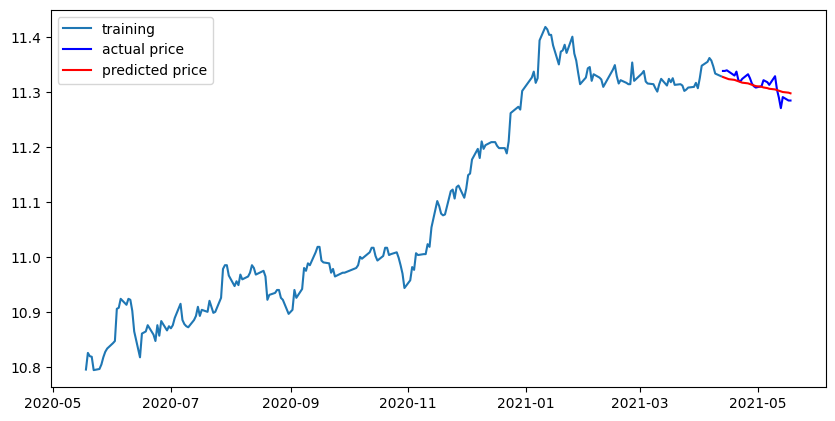

In [16]:
#forecast 메소드 이용 테스트 데이터 구간의 데이터를 예측
# Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [17]:
# 로그 변환된 데이터를 지수변환하여 정확한 오차 계산
# MSE, MAE, RMSE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1052831.3953688445
MAE:  840.325291750654
RMSE:  1026.0757259427028
MAPE: 1.02%


# 카카오

In [18]:
#카카오의 종가만 가져옴
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
kko = df['Close']
kko.head()

Date
2021-09-23    115845.671875
2021-09-24    120378.765625
2021-09-27    120882.445313
2021-09-28    118364.054688
2021-09-29    117356.703125
Name: Close, dtype: float64

In [19]:
# 결측치 처리
kko = kko.interpolate(method='time') # 결측치 보간. 보간기준 time
kko[kko.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [20]:
# 로그 변환 시도 
kko_log = np.log(kko)

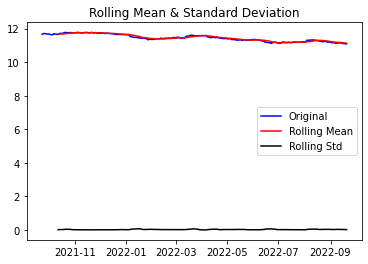

Results of Dickey-Fuller Test:
Test Statistic                  -0.431411
p-value                          0.904721
#Lags Used                       3.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


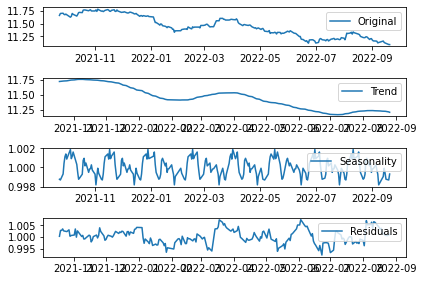

In [21]:
#시계열 안정성 분석

# 정성적 그래프 분석
 #이동평균을 이용한 구간 시각화
 # 좀더 뚜렷한 경향성을 확인 할 수 있다.

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(kko_log, window=12)

#정량적 Augmented Dicky-Fuller Test
# 시계열의 안정성을 테스트 하는 방법

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(kko_log)

#시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(kko_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(kko_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [22]:
# residuals 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# p-value 0.00007  매우 안정

Results of Dickey-Fuller Test:
Test Statistic                  -4.723861
p-value                          0.000076
#Lags Used                       3.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


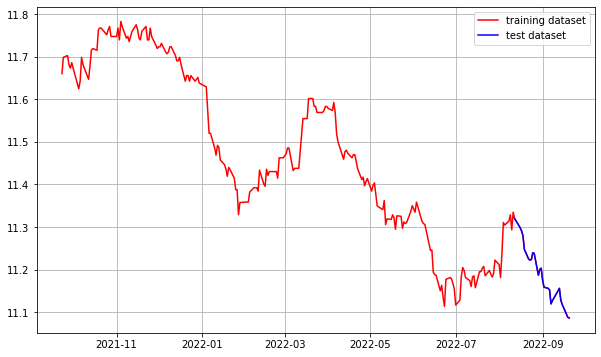

In [23]:
# 학습, 테스트 데이터 셋 분리
train_data, test_data = kko_log[:int(len(kko_log)*0.9)], kko_log[int(len(kko_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(kko_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 kko_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

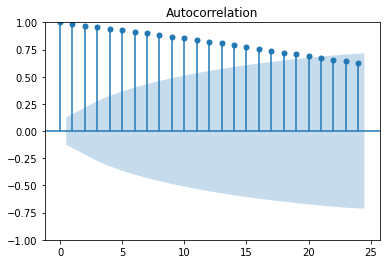

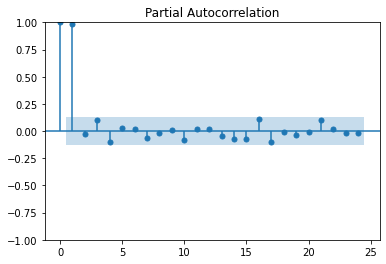

In [24]:
# 적정 ARIMA 모수 찾기
# ARIMA의 모수 3가지
# p : 자귀회귀 모형(AR)의 시차
# d : 차분 누적 횟수
# q : 이동평균 모형(MA)의 시차
# 일반적으로 q와 p는 p+q <2 , p*q= 0 인 값을 사용, 
# p*q = 0 은 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기때문
# international airline passengers 시계열 예시
# statsmodels에서 제공하는 ACF와 PACF 사용

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kko_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(kko_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# PACF를 를 보았을때 p는 1일때 매우 적합
# p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.
# PACF가 0이라는 의미는 현재 데이터와 p시점 떨어진 이전의 데이터는 상관도가 0,
# 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

# ACF는 점차적으로 감소하고 있음
# q에 대하서는 적합한 값이 없어 보임
# MA 를 고려할 필요가 없다면 q=0으로 둘 수 있음, 하지만 q를 바꿔가면서 확인해보는 것도 좋음

Results of Dickey-Fuller Test:
Test Statistic                -8.157327e+00
p-value                        9.343638e-13
#Lags Used                     2.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.796840e+00
p-value                        7.677436e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


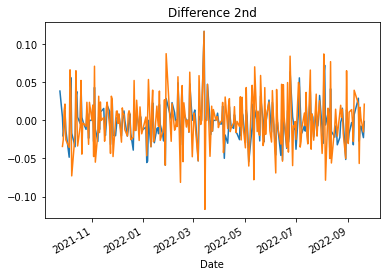

In [25]:
# 차분 안정성 구하기 (d)
# d를 구하기 위한 방법
# d차 차분을 구해보고 이때 시계열이 안정된 상태인지 확인

# 1차 차분 구하기
diff_1 = kko_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 1차분 매우 안정, 1차분 이나 0차분 사용

In [40]:
# 모델 훈련과 테스트

#모델 훈련
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 0)) # 모수는 이전 그래프를 참고 #(p,d, q) = (2, 0, 0)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  218
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 499.489
Date:                Tue, 20 Sep 2022   AIC                           -990.978
Time:                        08:17:48   BIC                           -977.440
Sample:                             0   HQIC                          -985.510
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4779      0.130     88.327      0.000      11.223      11.733
ar.L1          0.9636      0.076     12.639      0.000       0.814       1.113
ar.L2          0.0274      0.075      0.364      0.7

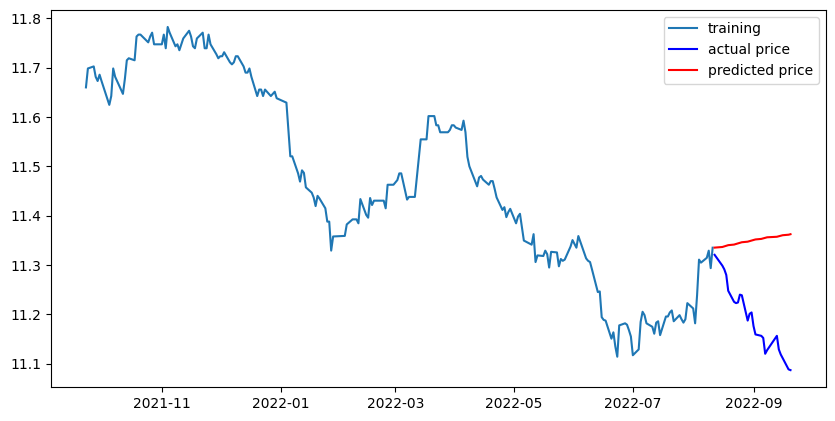

In [41]:
#forecast 메소드 이용 테스트 데이터 구간의 데이터를 예측
# Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [42]:
# 로그 변환된 데이터를 지수변환하여 정확한 오차 계산
# MSE, MAE, RMSE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  181876381.2487001
MAE:  12312.816718945873
RMSE:  13486.1551692356
MAPE: 17.53%


In [43]:
# ARIMA를 통한 시계열 예측을 통해 Kakao의 주가 예측을 해보았을 때,
# 굉장히 안정한 시계열 데이타를 통한 예측 임에도 불구하고 카카오는 예측을 벗어난 주가 행보를 보이고 있다.
# 이는 비특이적인 외부 요인에 의한 영향을 많이 받은 것으로 보여진다. (전쟁 등)
# TMI- 이러한 모델들을 통한 예측을 이미 확인하고 소액개인주주(개미)들이 이에따라 갈것을 예상하여,
# 경제 주체들(거대 자본, 정치, 경제 정책입안자)이 
# 예측을 벗어난 예상과 반하는 주가 행보를 만들어
# 막대한 경제적 이득을 창출 할 수도 있었던 것으로 보인다.
# 카카오야 올라가라

# 플레이디
 비특이적 영향을 많이 받지 않은 것 같은 차트의 예측

In [44]:
#플레이디의 종가만 가져옴
# 변수 새로 할당하지 않고 그대로 덮어써서 사용 함
# 모수 선정 및, 예측값이 맞는지 확인
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/237820.KQ.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
kko = df['Close']
kko.head()

Date
2022-09-20    5290.0
Name: Close, dtype: float64

In [45]:
kko.shape

(1,)

In [46]:
# 코스닥 주식에 대해서는 히스토리칼 데이터를 제공하지 않는 듯함
# 일정기준 이상의 코스피 주식에 대해서만 제공함

# 현대차
비특이적 영향을 많이 받지 않은 것 같은 차트의 예측

In [47]:
# 현대차의 종가만 가져옴
# 변수 새로 할당하지 않고 그대로 덮어써서 사용 함
# 적합한 모수 선정 및, 학습, 예측값이 맞는지 확인
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005380.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
kko = df['Close']
kko.head()

Date
2021-09-23    208500.0
2021-09-24    207000.0
2021-09-27    204000.0
2021-09-28    201500.0
2021-09-29    201500.0
Name: Close, dtype: float64

In [48]:
# 결측치 처리
kko = kko.interpolate(method='time') # 결측치 보간. 보간기준 time
kko[kko.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [49]:
# 로그 변환 시도 
kko_log = np.log(kko)

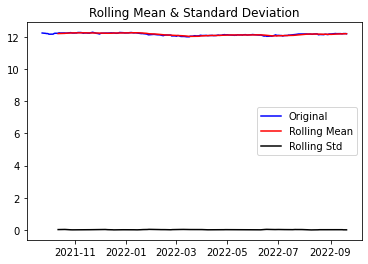

Results of Dickey-Fuller Test:
Test Statistic                  -1.590402
p-value                          0.488413
#Lags Used                       2.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


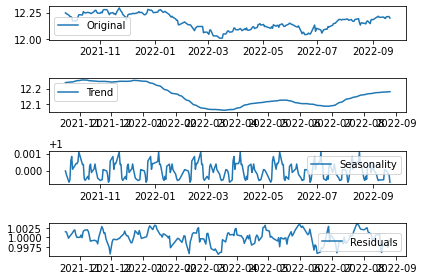

In [50]:
#시계열 안정성 분석

# 정성적 그래프 분석
 #이동평균을 이용한 구간 시각화
 # 좀더 뚜렷한 경향성을 확인 할 수 있다.

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(kko_log, window=12)

#정량적 Augmented Dicky-Fuller Test
# 시계열의 안정성을 테스트 하는 방법

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(kko_log)

#시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(kko_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(kko_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [51]:
# residuals 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# p-value 약 0.0001  매우 안정

Results of Dickey-Fuller Test:
Test Statistic                  -4.664074
p-value                          0.000098
#Lags Used                       2.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


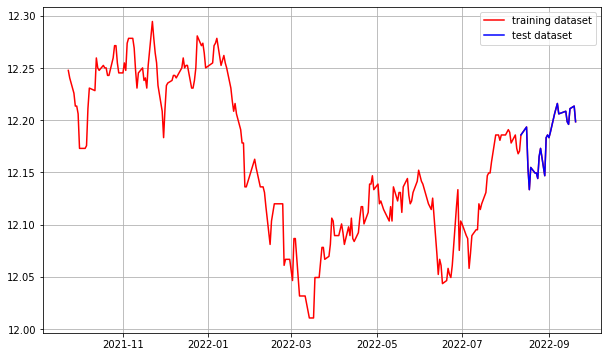

In [52]:
# 학습, 테스트 데이터 셋 분리
train_data, test_data = kko_log[:int(len(kko_log)*0.9)], kko_log[int(len(kko_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(kko_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 kko_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

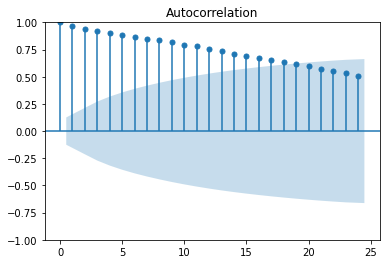

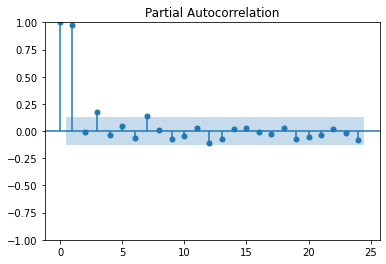

In [53]:
# 적정 ARIMA 모수 찾기
# ARIMA의 모수 3가지
# p : 자귀회귀 모형(AR)의 시차
# d : 차분 누적 횟수
# q : 이동평균 모형(MA)의 시차
# 일반적으로 q와 p는 p+q <2 , p*q= 0 인 값을 사용, 
# p*q = 0 은 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기때문
# international airline passengers 시계열 예시
# statsmodels에서 제공하는 ACF와 PACF 사용

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kko_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(kko_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# PACF를 를 보았을때 p는 1일때 매우 적합
# p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.
# PACF가 0이라는 의미는 현재 데이터와 p시점 떨어진 이전의 데이터는 상관도가 0,
# 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

# ACF는 점차적으로 감소하고 있음
# q에 대하서는 적합한 값이 없어 보임
# MA 를 고려할 필요가 없다면 q=0으로 둘 수 있음, 하지만 q를 바꿔가면서 확인해보는 것도 좋음

Results of Dickey-Fuller Test:
Test Statistic                -1.294075e+01
p-value                        3.539014e-24
#Lags Used                     1.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.014093e+00
p-value                        6.015718e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


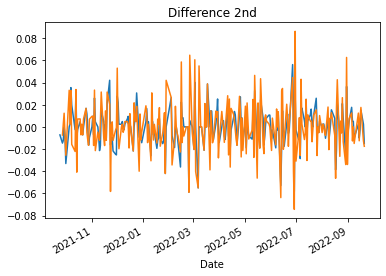

In [54]:
# 차분 안정성 구하기 (d)
# d를 구하기 위한 방법
# d차 차분을 구해보고 이때 시계열이 안정된 상태인지 확인

# 1차 차분 구하기
diff_1 = kko_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 1차분 매우 안정, 1차분 이나 0차분 사용

In [60]:
# 모델 훈련과 테스트

#모델 훈련
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 1)) # 모수는 이전 그래프를 참고 하여 선정
#(p,d, q) = (2, 1, 1)
# d 값은 0차와 1차 값 어떤것을 사용해도 크게 차이는 없었다.
# q 는 1을 사용 q 값이 큰값을 사용할 수록 예측 그래프는 단순한 선형에서 자세한 그래프로 바뀌는 듯함
# 위 데이타의 경우 낮은 q(자귀회귀 모형(AR)의 시차)값을 사용할수록 Autocorrelation 값이 커져서 그런 듯함

fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  218
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 588.557
Date:                Tue, 20 Sep 2022   AIC                          -1169.115
Time:                        10:04:04   BIC                          -1155.595
Sample:                             0   HQIC                         -1163.653
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6155      0.219     -2.817      0.005      -1.044      -0.187
ar.L2         -0.1263      0.070     -1.798      0.072      -0.264       0.011
ma.L1          0.6435      0.216      2.973      0.0

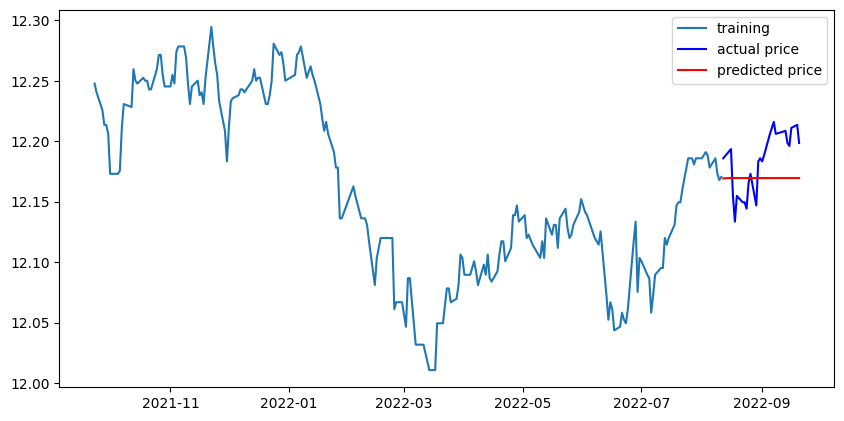

In [61]:
#forecast 메소드 이용 테스트 데이터 구간의 데이터를 예측
# Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [57]:
# 로그 변환된 데이터를 지수변환하여 정확한 오차 계산
# MSE, MAE, RMSE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  28127768.985576168
MAE:  4796.834143391711
RMSE:  5303.561914937561
MAPE: 2.44%


In [ ]:
# 모델은 횡보할 것으로 예측했고
# 테스트 구간내(최근 약 5주간)의 실제데이터는 하락후 약한 우상향 그래프 처럼 보이나 
# 실제값과 비슷하게 예측한 것으로 보인다. 테스트 구간의 MAPE = 2.44%
# 외부의 비특이적인 영향을 추후 많이 받지 않을 것으로 보이는 차트의경우
# 앞으로 비특이적영향을 받지 않을 것이란 가정하에,
# MA는 일정 부분은 예상을 해볼 수도 있지만 추천하지 않는다.
